# Benchmark interpolation

Test the adjoint of `scipy.interpolate.RegularGridInterpolator` and a nearest neighbour interpolation using `scipy.spatial.cKDTree`.

The latter works correctly, but it would be nice to one day have linear interpolation.

In [1]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator as RGI
import itertools

In [2]:
class RegularGridInterpolator(RGI):

    def __init__(self, points, values, method="linear", bounds_error=False, fill_value=np.nan):

        super(RegularGridInterpolator, self).__init__(points, values, method, bounds_error, fill_value)


    def adjoint(self, xi, dxi, method=None):
        """
        Interpolation adjoint using the derivatives dxi at coordinates xi
        Parameters
        ----------
        xi : ndarray of shape (..., ndim)
            The coordinates to sample the gridded data at
        dxi : ndarray of shape (..., ndim)
             The derivatives at the coordinates xi
        method : str
                The method of interplolation to perform.
                Supports either 'linear' or 'nearest'
        """
        if method is None:
            method = self.method
            
        self.derivative = np.asarray(dxi)
        indices, norm_distances, out_of_bounds = self._find_indices(xi.T)
        if method == "linear":
            result = self._evaluate_linear_adjoint(indices, norm_distances, out_of_bounds)
        elif method == "nearest":
            result = self._evaluate_nearest_adjoint(indices, norm_distances, out_of_bounds)
        return result

    def _evaluate_linear_adjoint(self, indices, norm_distances, out_of_bounds):
        # slice for broadcasting over trailing dimensions in self.values
        vslice = (slice(None),) + (None,)*(self.values.ndim - len(indices))
        # find relevant values
        # each i and i+1 represents a edge
        edges = itertools.product(*[[i, i + 1] for i in indices])
        all_values = []
        for edge_indices in edges:
            values = np.zeros_like(self.values)
            weight = 1.
            for ei, i, yi in zip(edge_indices, indices, norm_distances):
                weight *= np.where(ei == i, 1 - yi, yi)
            print np.array(edge_indices).shape, np.array(weight[vslice]).shape, self.derivative.shape, weight[vslice].shape, values.shape
            values[edge_indices] += self.derivative * weight[vslice]
            all_values.append(values)
        
        print all_values
        print np.sum(all_values, axis=0)
#         values = self.derivative * np.array(all_values)
        
        return np.sum(all_values, axis=0)

    def _evaluate_nearest_adjoint(self, indices, norm_distances, out_of_bounds):
        idx_res = []
        values = np.zeros_like(self.values)
        for i, yi in zip(indices, norm_distances):
            idx_res.append(np.where(yi <= 0.5, i, i + 1))
            
        idx_res = np.array(idx_res).T
        for i, ix in enumerate(idx_res):
            # This almost works
            values[ix] += self.derivative[i]

        return values

In [3]:
class nearest_nd(object):
    def __init__(self, points, values, bounds_error=False, fill_value=np.nan):
        from scipy.spatial import cKDTree
        self.tree = cKDTree(points)
        data = self.tree.data
        npoints, ndim = data.shape
        
        self.fill_value = fill_value
        self.bounds_error = bounds_error
        
        bbox = []
        for i in range(0, ndim):
            bbox.append((data[:,i].min(), data[:,i].max()))
        
        self.npoints = npoints
        self.ndim = ndim
        self.bbox = bbox
        
        self._values = np.ravel(values)
        
    def __call__(self, xi, *args, **kwargs):
        idx, d, bmask = self._find_indices(xi)
        
        if self.bounds_error and bmask.any():
            bidx = np.nonzero(bmask)[0]
            raise ValueError("Coordinates in xi are out of bounds in:\n {}".format(bidx))
        
        vi = self.values[idx]
        if not self.bounds_error and self.fill_value is not None:
            vi[bmask] = self.fill_value
        
        return vi
    
    def adjoint(self, xi, dxi, *args, **kwargs):
        idx, d, bmask = self._find_indices(xi)
        
        if self.bounds_error and bmask.any():
            bidx = np.nonzero(bmask)[0]
            raise ValueError("Coordinates in xi are out of bounds in:\n {}".format(bidx))
        
        dv = np.zeros_like(self.values)
        if not self.bounds_error and self.fill_value is not None:
            # remove indices that are out of bounds
            idx = idx[~bmask]
        
        ux = np.unique(idx)
        for u in ux:
            dv[u] = dxi[idx==u].sum()
            
        return dv
    
    def _find_indices(self, xi):
        d, idx = self.tree.query(xi)
        bbox = self.bbox
        ndim = self.ndim
        
        bounds = np.zeros(idx.size, dtype=bool)
        for i in range(0, ndim):
            bmin, bmax = bbox[i]
            mask = np.logical_or(xi[:,i] < bmin, xi[:,i] > bmax)
            bounds[mask] = True
            
        return idx, d, bounds
            
    
    @property
    def values(self):
        return self._values
    @values.setter
    def values(self, value):
        self._values = value.ravel()
    @values.getter
    def values(self):
        return self._values

In [4]:
minX, maxX = 0., 1.
minY, maxY = 0., 1.
nx, ny = 5, 5

Xcoords = np.linspace(minX, maxX, nx)
Ycoords = np.linspace(minY, maxY, ny)

xq, yq = np.meshgrid(Xcoords, Ycoords, indexing='ij')

In [5]:
v = np.exp(xq**2 + yq**2)
interp = RegularGridInterpolator((Ycoords, Xcoords), v)

In [6]:
# Create some coordinates

nobs = 40

vobs = np.ones(nobs)*3
sigma_vobs = vobs*0.1

xi = np.zeros((nobs,2))
xi[:,0] = np.linspace(minY, maxY, nobs)
xi[:,1] = np.linspace(minX, maxX, nobs)

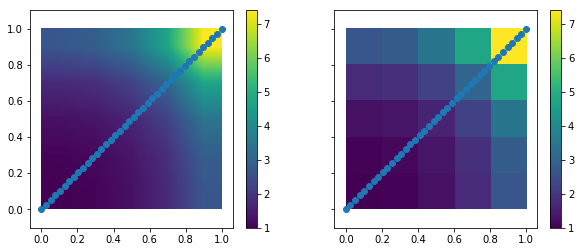

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(10,4))

im1 = ax1.imshow(v, extent=(minX, maxX, minY, maxY), origin='lower', interpolation='bilinear')
ax1.scatter(xi[:,0], xi[:,1])
fig.colorbar(im1, ax=ax1)

im2 = ax2.imshow(v, extent=(minX, maxX, minY, maxY), origin='lower', interpolation='nearest')
ax2.scatter(xi[:,0], xi[:,1])
fig.colorbar(im2, ax=ax2)

In [8]:
# interp = RegularGridInterpolator((Ycoords, Xcoords), v)
interp = nearest_nd(np.column_stack([xq.ravel(), yq.ravel()]), v.ravel())

In [9]:
method = 'nearest'
v = np.exp(xq**2 + yq**2)
dv = v*0.1

def forward_model(v):
    interp.values = v
    vi = interp(xi, method=method)
    cost = np.sum((vi - vobs)**2)
    return cost

def tangent_linear(v, dv):
    interp.values = v
    vi = interp(xi, method=method)
    interp.values = dv
    dvi = interp(xi, method=method)
    dcdvi = 2.0*(vi - vobs)
    dc = dcdvi * dvi
    return dc.sum()

def adjoint(v):
    interp.values = v
    vi = interp(xi, method=method)
    dcdvi = 2.0*(vi - vobs)
    dvi = dcdvi*1.0
    dv_ad = interp.adjoint(xi, dvi, method=method)
    return dv_ad

In [10]:
fm0 = forward_model(v)
fm1 = forward_model(v+dv)
tl  = tangent_linear(v, dv)
ad  = adjoint(v)
print "finite difference", (fm1 - fm0)
print "tangent linear", tl
print "adjoint", ad.ravel().dot(dv.ravel())

finite difference 26.3674602731
tangent linear 22.2385484633
adjoint 22.2385484633
